# CIFAR-10: Training, Validation and Inference
### with PyTorch


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

## Preparing CIFAR-10 Dataset

In [2]:
# Dataset Directory
data_dir = './cifar-10'

# Defining transformations for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Downloading and applying transforms
train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transforms)
test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transforms)

Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10
Files already downloaded and verified


## Loading the Dataset

In [3]:
# Batch Size
batch = 128

# Percentage of training set to use as validation
valid_size = 0.2

# Obtaining training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch,
                                          sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_set, batch_size=batch,
                                          sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch,
                                         shuffle=False)

classes = ['airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck']

## Visualizing the Dataset

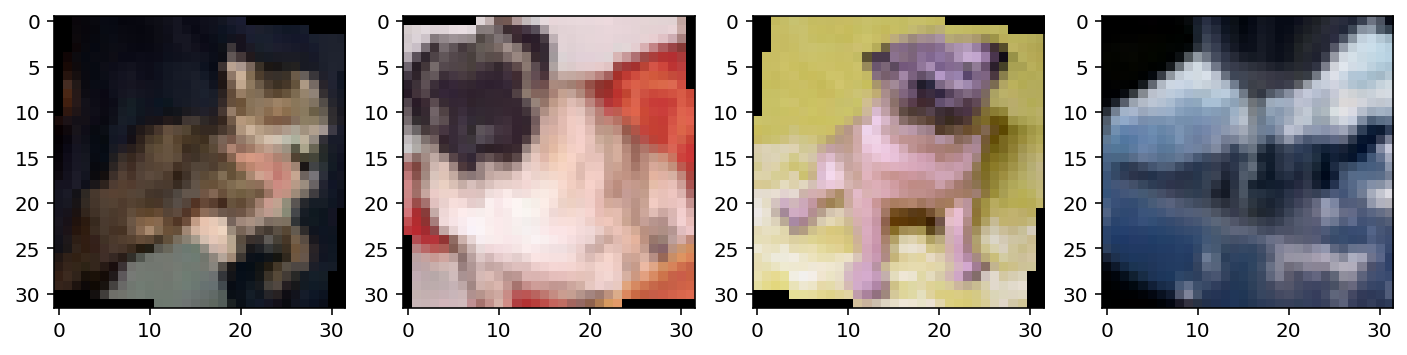

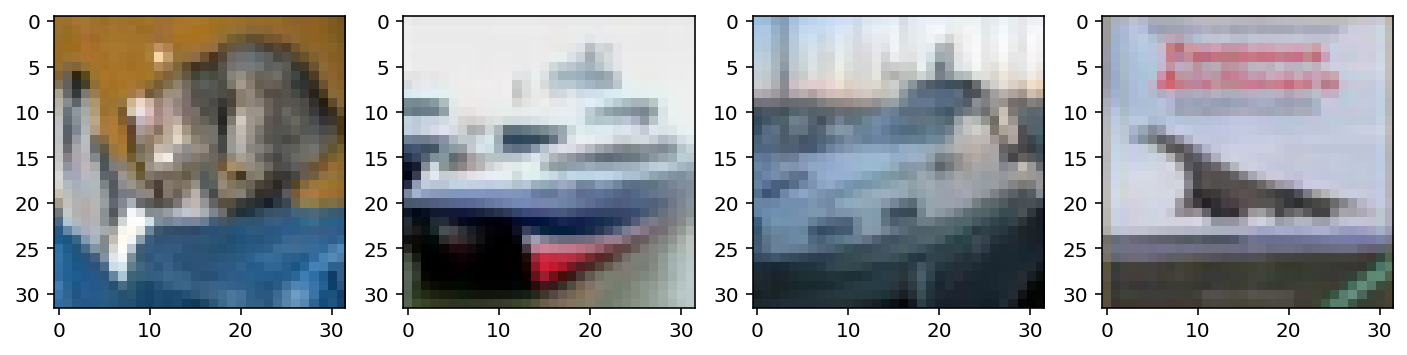

In [4]:
def unnormalize(img):
  return (img / 2 + 0.5)

def plot_img(img):
  fig, ax = plt.subplots(figsize=(12,18), ncols=4)
  ax[0].imshow(unnormalize(img[0]).numpy().transpose(1, 2, 0))
  ax[1].imshow(unnormalize(img[1]).numpy().transpose(1, 2, 0))
  ax[2].imshow(unnormalize(img[2]).numpy().transpose(1, 2, 0))
  ax[3].imshow(unnormalize(img[3]).numpy().transpose(1, 2, 0))

# Training Set
train_images, train_labels = next(iter(trainloader))
plot_img(train_images)

# Testing Set
test_images, test_labels = next(iter(testloader))
plot_img(test_images)

## Checking for CUDA devices

In [5]:
# Checking and selecting appropriate device
if torch.cuda.is_available():
    print("CUDA compatible device found, using that...\n")
    device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(device=device))
else:
    device = torch.device("cpu")

CUDA compatible device found, using that...

Tesla P4


## Defining a Neural Network using ReLU as an activation function

A torch implementation of the sequential CNN model based on Keras CIFAR-10 implementation but with batch normalization and some customization.


In [6]:
# Flattening for sequential model
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Defining a sequential NN model
model = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.BatchNorm2d(32),
                      nn.Dropout(0.25),
                      nn.Conv2d(32, 64, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.BatchNorm2d(128),
                      nn.Dropout(0.25),
                      Flatten(),
                      nn.Linear(4608, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

# Testing model by forwarding one batch
model.forward(train_images)

tensor([[-2.6327, -2.2396, -2.5978,  ..., -1.6351, -2.7235, -2.7985],
        [-1.8120, -1.5144, -2.8748,  ..., -2.2439, -2.5991, -2.4749],
        [-2.6577, -2.4270, -2.0176,  ..., -2.0606, -2.3630, -2.4465],
        ...,
        [-2.1240, -2.5724, -2.0699,  ..., -2.4369, -2.4406, -2.3076],
        [-2.3375, -2.1331, -2.0233,  ..., -2.3891, -2.3061, -2.5852],
        [-2.6548, -2.1039, -1.7060,  ..., -2.1101, -2.0261, -2.6009]],
       grad_fn=<LogSoftmaxBackward>)

## Selecting appropriate loss criterion and gradient optimizer

In [7]:
# Cross Entropy Loss Criterion
criterion = nn.CrossEntropyLoss()

# RMSprop Gradient Optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [ ]:
# Moving model to selected device
model.to(device)

# Defining some stats vars
epochs = 100
epochs_time = []
steps = 0
train_losses, valid_losses, valid_accuracy, total_steps = [], [], [], []
running_loss = 0
valid_loss = 0
accuracy = 0
validate_every = 2*batch

total_time = time.time()

for e in range(epochs):
  epoch_time = time.time()
  for images, labels in trainloader:
      steps += 1

      # Moving image and label tensors to the specific device
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      log_ps =  model.forward(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      
      optimizer.step()

      running_loss += loss.item()

      if steps % validate_every == 0:
          # Setting model to evaluation mode
          model.eval()

          # Turning off gradients for validation, saves memory and computations
          with torch.no_grad():

              # Validation pass here
              for images, labels in validloader:

                  # Moving image and label tensors to the specific device
                  images, labels = images.to(device), labels.to(device)

                  log_ps = model.forward(images)
                  batch_loss = criterion(log_ps, labels)
                  valid_loss += batch_loss.item()

                  # Calculating Accuracy
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

          train_losses.append(running_loss/len(trainloader))
          valid_losses.append(valid_loss/len(validloader))
          valid_accuracy.append(accuracy/len(validloader))
          total_steps.append(steps)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/validate_every),
                "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                "Validation Accuracy: {:.3f}.. ".format(accuracy/len(validloader)),
                "Epoch Time: {:.3f}".format(time.time() - epoch_time))

          running_loss = 0
          valid_loss = 0
          accuracy = 0

          # Setting model back to train mode
          model.train()
  
  epochs_time.append(time.time() - epoch_time)

total_time = time.time() - total_time
print("\nTraining and Validation of ", epochs, " finished in ", total_time)

Epoch: 1/100..  Training Loss: 1.490..  Validation Loss: 1.361..  Validation Accuracy: 0.510..  Epoch Time: 23.280
Epoch: 2/100..  Training Loss: 1.267..  Validation Loss: 1.283..  Validation Accuracy: 0.544..  Epoch Time: 18.859
Epoch: 3/100..  Training Loss: 1.170..  Validation Loss: 1.258..  Validation Accuracy: 0.560..  Epoch Time: 14.696
Epoch: 4/100..  Training Loss: 1.088..  Validation Loss: 1.186..  Validation Accuracy: 0.581..  Epoch Time: 10.306
Epoch: 5/100..  Training Loss: 1.041..  Validation Loss: 1.083..  Validation Accuracy: 0.619..  Epoch Time: 6.049
Epoch: 5/100..  Training Loss: 0.991..  Validation Loss: 1.018..  Validation Accuracy: 0.642..  Epoch Time: 29.404
Epoch: 6/100..  Training Loss: 0.944..  Validation Loss: 0.979..  Validation Accuracy: 0.655..  Epoch Time: 20.941
Epoch: 7/100..  Training Loss: 0.914..  Validation Loss: 0.960..  Validation Accuracy: 0.666..  Epoch Time: 16.678
Epoch: 8/100..  Training Loss: 0.883..  Validation Loss: 0.910..  Validation Accu

## Plotting Loss and Acurracy Stats

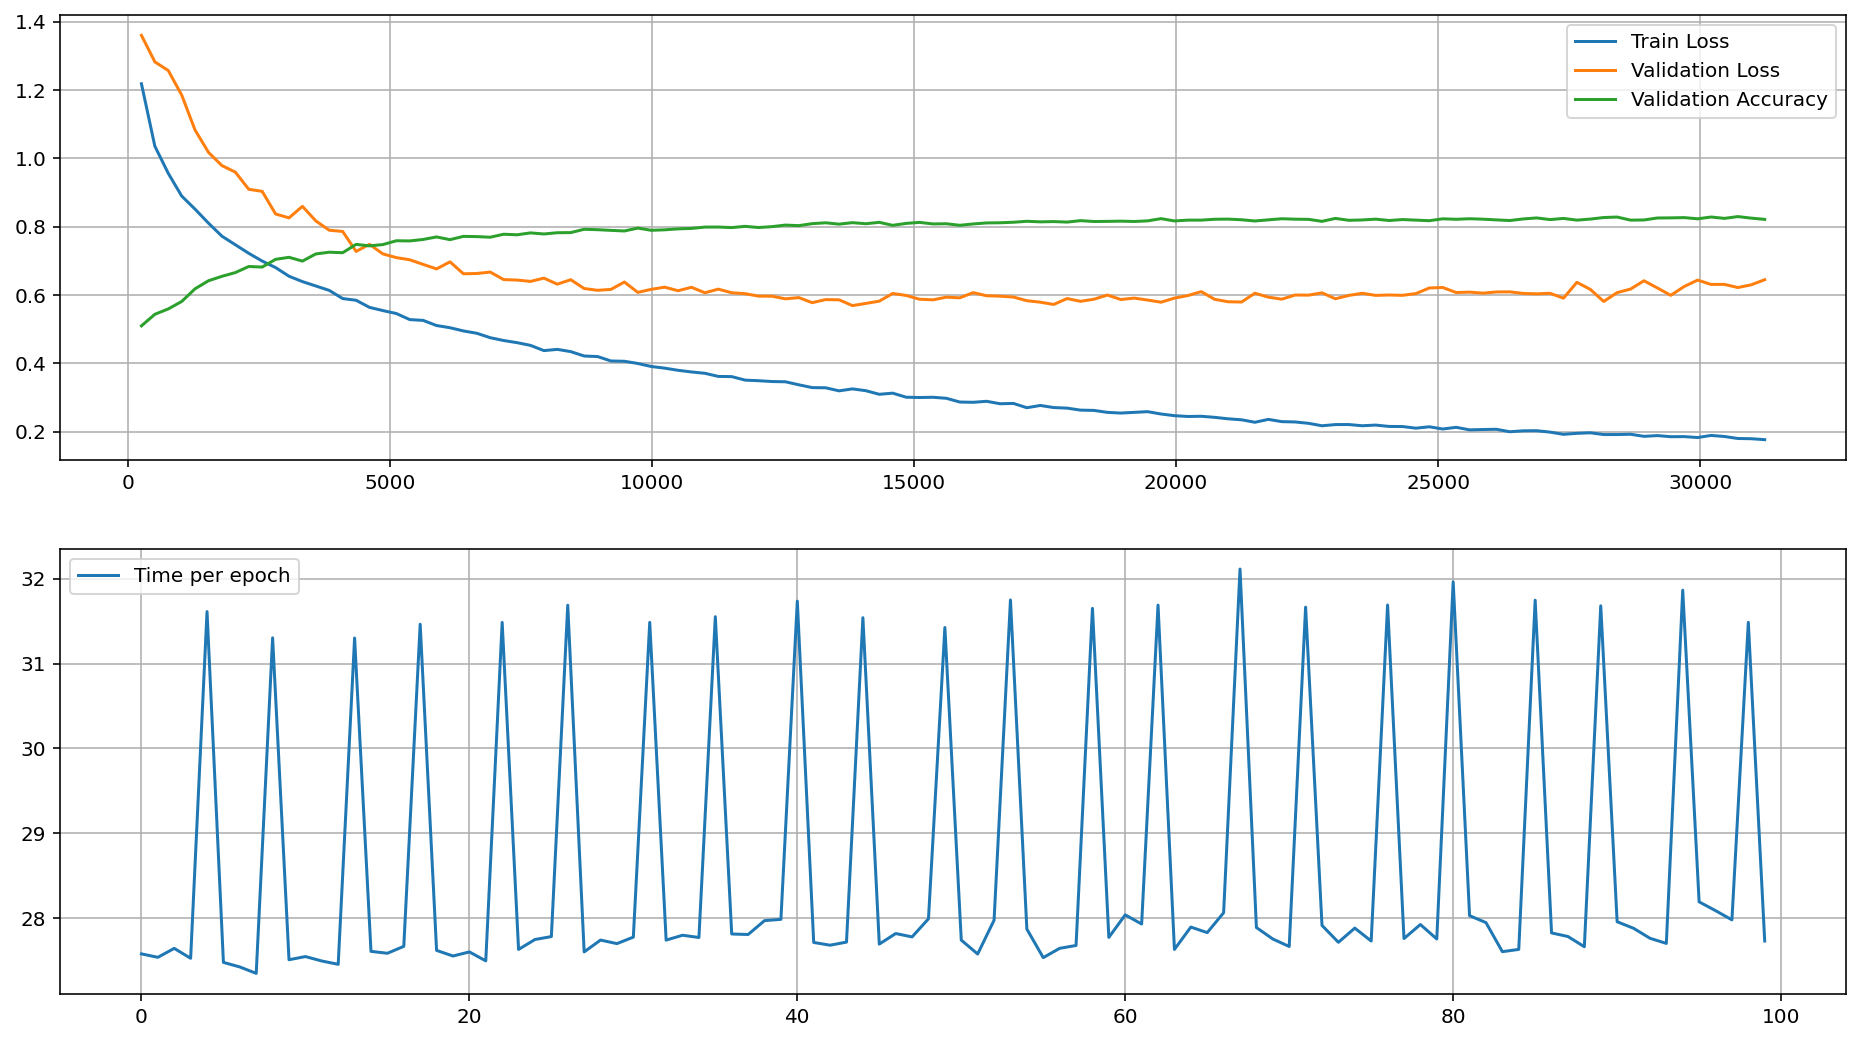

In [ ]:
# Graphing losses and accuracy
fig, ax = plt.subplots(figsize=(16, 9), nrows=2)
ax[0].plot(total_steps, train_losses, label='Train Loss')
ax[0].plot(total_steps, valid_losses, label='Validation Loss')
ax[0].plot(total_steps, valid_accuracy, label='Validation Accuracy')
ax[0].legend()

ax[1].plot(range(epochs), epochs_time, label='Time per epoch')
ax[1].legend()

ax[0].grid()
ax[1].grid()
plt.show()

## Saving a model checkpoint

In [ ]:
# Creating a model checkpoint
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

# Saving model checkpoint
torch.save(checkpoint, './CIFAR-10-pytorch.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Predicting from the saved checkpoint

In [7]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# explicit flattening
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# reload model
model = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.BatchNorm2d(32),
                      nn.Dropout(0.25),
                      nn.Conv2d(32, 64, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.BatchNorm2d(128),
                      nn.Dropout(0.25),
                      Flatten(),
                      nn.Linear(4608, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))
checkpoint = torch.load('./CIFAR-10-pytorch.pth', map_location=device)
model.parameters = checkpoint['parameters']
model.load_state_dict(checkpoint['state_dict'])

model.eval()
ii = 0

# iterate over test data
for batch_idx, (data, target) in enumerate(testloader):
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss 
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy())
  # calculate test accuracy for each object class
  for i in range(batch):
    if ii >= len(testloader.dataset):
      break
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    ii+=1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: \t%2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
  100. * np.sum(class_correct) / np.sum(class_total),
  np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.760377

Test Accuracy of airplane: 	82% (824/1000)
Test Accuracy of automobile: 	90% (903/1000)
Test Accuracy of  bird: 	71% (716/1000)
Test Accuracy of   cat: 	63% (630/1000)
Test Accuracy of  deer: 	85% (856/1000)
Test Accuracy of   dog: 	75% (752/1000)
Test Accuracy of  frog: 	90% (900/1000)
Test Accuracy of horse: 	86% (860/1000)
Test Accuracy of  ship: 	91% (911/1000)
Test Accuracy of truck: 	91% (913/1000)

Test Accuracy (Overall): 82% (8265/10000)


## Predicting a random image from web

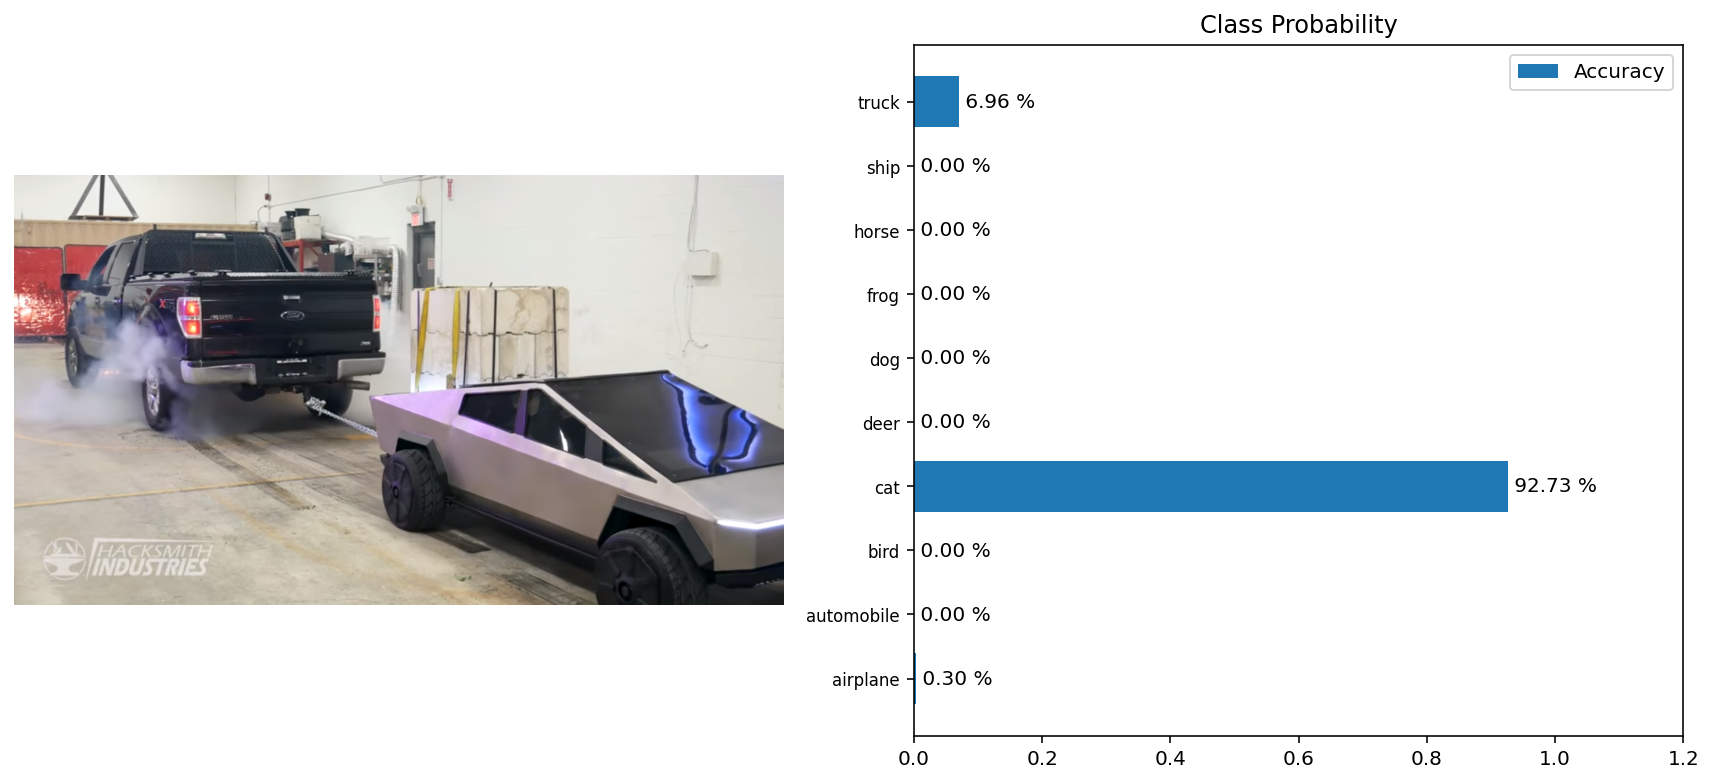

In [14]:
import requests
from io import BytesIO
from PIL import Image

pred_transforms = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

plotting_transform = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.ToTensor()])

def image_transform_url(imageurl):
    global image
    response = requests.get(imageurl)
    image = Image.open(BytesIO(response.content))
    imagetensor = pred_transforms(image)
    return imagetensor

def predict(imagepath):
    image = image_transform_url(imagepath)
    image1 = image[None,:,:,:]
    ps = torch.exp(model(image1))
    return ps

def imshow(image):
    fig, ax = plt.subplots()
    image_tensor = plotting_transform(image).permute(1, 2, 0)
    ax.imshow(image_tensor)
    return ax

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(12,18), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    
    ax2.barh(np.arange(10), ps, label='Accuracy')
    for i, v in enumerate(ps):
      ax2.text(v, i, " {:.2f} %".format(v*100), va='center')
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.2)
    ax2.legend()

    plt.tight_layout()

# Predicting from a network image
# I will just leave this here :D
prediction = predict(r"https://www.thesun.co.uk/wp-content/uploads/2020/03/33-1.png")
view_classify(image, prediction)